# Create data to perform Multiple Sequnce Alignment for fep system in Escherichia coli cohort

## Read `fep system` gene sequences

In [1]:
import os
from pathlib import Path

import pandas as pd

from Bio.SeqRecord import SeqRecord

from io import StringIO

geneNames = ['fepA', 'fepB', 'fepC', 'fepD', 'fepE', 'fepG'] # list obtained from this paper

fastaData = {}
gff3Path = Path(os.environ['GENOMICS_DATA_BASE'], 'annotations', 'e_coli', 'gff3_original')

dfList = []

for gff3FileName in os.listdir(gff3Path):

    gff3File = Path(gff3Path, gff3FileName)

    tubeId = gff3FileName.split('.')[0]

    gff3Lines = []
    fasta_start_index = None
    with open(gff3File, 'r') as in_handle:
        gff3Lines = in_handle.readlines()

    for i, line in enumerate(gff3Lines):
        if line.strip() == "##FASTA":
            fasta_start_index = i + 1
            break

    gff3Info = StringIO("".join(gff3Lines[: fasta_start_index]))

    df = pd.read_csv(gff3Info, sep='\t', comment='#', header=None, names=['seq_id', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'])
    df['gene'] = df.attributes.str.split(';').apply(lambda x: [item.split('=')[1] for item in x if item.split('=')[0] == 'gene']).apply(lambda x: x[0] if x else None)
    df = df[df.gene.isin(geneNames)]
    df['tube_id'] = tubeId

    dfList.append(df)

allGenesDf = pd.concat(dfList, ignore_index=True)
allGenesDf

,seq_id,source,type,start,end,score,strand,phase,attributes,gene,tube_id
0,1,Prodigal,CDS,3487,5859,.,-,0,ID=EFLFLN_00010;Name=Outer membrane receptor f...,fepA,AH19A073
1,14,Prodigal,CDS,20974,23214,.,-,0,ID=EFLFLN_17535;Name=ferrienterobactin outer m...,fepA,AH19A073
2,14,Prodigal,CDS,28974,30107,.,+,0,ID=EFLFLN_17555;Name=LPS O-antigen length regu...,fepE,AH19A073
3,14,Prodigal,CDS,30104,30919,.,-,0,ID=EFLFLN_17560;Name=ferrienterobactin ABC tra...,fepC,AH19A073
4,14,Prodigal,CDS,30916,31908,.,-,0,ID=EFLFLN_17565;Name=iron-enterobactin ABC tra...,fepG,AH19A073
...,...,...,...,...,...,...,...,...,...,...,...
11676,4,Prodigal,CDS,186059,187081,.,-,0,ID=GOAIKP_09045;Name=ABC-type Fe3+-hydroxamate...,fepB,AH19K033
11677,5,Prodigal,CDS,247544,248353,.,+,0,ID=GOAIKP_11135;Name=ABC-type cobalamin/Fe3+-s...,fepC,AH19K033
11678,5,Prodigal,CDS,248350,249333,.,+,0,ID=GOAIKP_11140;Name=ABC-type Fe3+-siderophore...,fepD,AH19K033
11679,5,Prodigal,CDS,249330,250379,.,+,0,ID=GOAIKP_11145;Name=ABC-type Fe3+-siderophore...,fepD,AH19K033


## Explore

In [2]:
allGenesDf.seq_id.value_counts()

seq_id
1      1912
2      1441
3      1163
4      1107
5       749
       ... 
54        1
100       1
167       1
96        1
52        1
Name: count, Length: 70, dtype: int64

In [3]:
import pandas as pd
import numpy as np


pivotedGenesDf = pd.pivot_table(data=allGenesDf[['gene', 'tube_id']], columns='gene', index='tube_id', aggfunc=np.count_nonzero).fillna(0).astype(bool)
pivotedGenesDf

gene,fepA,fepB,fepC,fepD,fepE,fepG
tube_id,,,,,,
AH18J011,True,True,True,True,True,True
AH18J016,True,True,True,True,True,True
AH18J019,True,True,True,True,True,True
AH18J032,True,True,True,True,True,True
AH18J033,True,True,True,True,True,True
...,...,...,...,...,...,...
ALF23C186,True,True,True,True,False,True
ALF23C187,True,True,True,True,True,True
ALF23C213,True,True,True,True,False,True


In [4]:
pivotedGenesDf.reset_index(drop=True).sum()

gene
fepA    860
fepB    861
fepC    861
fepD    861
fepE    808
fepG    861
dtype: int64

In [8]:
groupedGenesDf = allGenesDf[allGenesDf.gene.isin(['fepA', 'fepB', 'fepC', 'fepD', 'fepG'])].groupby(by=['tube_id', 'gene'])['seq_id'].agg(list_of_contigs=lambda x: set(x)).reset_index()
groupedGenesDf.list_of_contigs.apply(lambda x: len(x)).value_counts()
# groupedGenesDf

list_of_contigs
3    2434
1    1131
2     643
4      96
Name: count, dtype: int64

In [9]:
groupedGenesDf['contig'] = groupedGenesDf.list_of_contigs.apply(lambda x: list(x)[0])
groupedGenesDf

,tube_id,gene,list_of_contigs,contig
0,AH18J011,fepA,"{1, 28, 5}",1
1,AH18J011,fepB,"{1, 2, 5}",1
2,AH18J011,fepC,"{1, 2, 5}",1
3,AH18J011,fepD,"{1, 2, 5}",1
4,AH18J011,fepG,{1},1
...,...,...,...,...
4299,ALF23C222,fepA,"{2, 3, 21}",2
4300,ALF23C222,fepB,"{2, 3, 4}",2
4301,ALF23C222,fepC,"{2, 3, 4}",2
4302,ALF23C222,fepD,"{2, 3, 4}",2


In [51]:
geneLocationsDf = groupedGenesDf.merge(
    allGenesDf[['seq_id', 'start', 'end', 'gene', 'tube_id']],
    how='inner',
    left_on=['tube_id', 'gene', 'contig'],
    right_on=['tube_id', 'gene', 'seq_id']
)[['tube_id', 'gene', 'contig', 'start', 'end']].groupby(
    by=['tube_id', 'gene', 'contig']
).agg('first').reset_index()
geneLocationsDf

,tube_id,gene,contig,start,end
0,AH18J001,esaA,1,254364,257393
1,AH18J001,esaB,1,257823,258065
2,AH18J001,essA,1,257393,257851
3,AH18J001,essB,1,258078,259412
4,AH18J001,essC,1,259434,263879
...,...,...,...,...,...
3628,ALF23C188,essA,1,455720,456178
3629,ALF23C188,essB,1,456405,457739
3630,ALF23C188,essC,1,457761,462200
3631,ALF23C188,esxA,1,452315,452608


In [74]:
groupLocationsDf = geneLocationsDf.groupby(by=['tube_id', 'contig']).agg({'start': 'min', 'end': 'max'}).reset_index()
groupLocationsDf['seq_length'] = (groupLocationsDf.end - groupLocationsDf.start)
groupLocationsDf = groupLocationsDf[groupLocationsDf.seq_length > 9000]
groupLocationsDf

,tube_id,contig,start,end,seq_length
0,AH18J001,1,253987,263879,9892
1,AH18J002,5,4930,14806,9876
2,AH18J014,11,11183,22812,11629
3,AH18J021,1,171752,181647,9895
4,AH18J022,5,171802,181697,9895
...,...,...,...,...,...
555,ALF23C134,3,172481,184109,11628
556,ALF23C140,1,164084,175712,11628
557,ALF23C174,1,678446,690074,11628
558,ALF23C182,6,158985,168861,9876


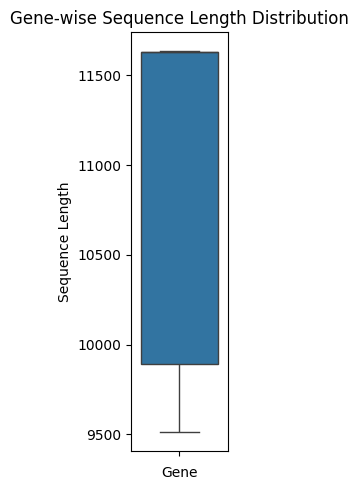

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have groupLocationsDf loaded as a DataFrame

# Group by gene and collect all sequence lengths
plt.figure(figsize=(2, 5))
sns.boxplot(data=groupLocationsDf, y="seq_length")

# Optional aesthetics
plt.xticks(rotation=45, ha='right')
plt.title("Gene-wise Sequence Length Distribution")
plt.xlabel("Gene")
plt.ylabel("Sequence Length")
plt.tight_layout()
plt.show()

## Function to obtain sequence

In [76]:
def getSequenceData(gff3Lines, fasta_start_index, seqId, startLocation, endLocation):

    from io import StringIO
    from Bio import SeqIO

    fasta_data = StringIO("".join(gff3Lines[fasta_start_index:]))
    seq_dict = SeqIO.to_dict(SeqIO.parse(fasta_data, "fasta"))

    return seq_dict[seqId][startLocation - 1:endLocation]

## Create FASTA data from location information

In [88]:
import os
from pathlib import Path

import pandas as pd

from Bio.SeqRecord import SeqRecord

from io import StringIO


fastaData = {}
gff3Path = Path(os.environ['GENOMICS_DATA_BASE'], 'annotations', 's_aureus', 'gff3_original_v1')

dfList = []

for gff3FileName in os.listdir(gff3Path):

    gff3File = Path(gff3Path, gff3FileName)

    tubeId = gff3FileName.split('.')[0]

    gff3Lines = []
    fasta_start_index = None
    with open(gff3File, 'r') as in_handle:
        gff3Lines = in_handle.readlines()

    for i, line in enumerate(gff3Lines):
        if line.strip() == "##FASTA":
            fasta_start_index = i + 1
            break

    if(not groupLocationsDf[groupLocationsDf.tube_id == tubeId].empty):
        record = getSequenceData(
            gff3Lines=gff3Lines,
            fasta_start_index=fasta_start_index,
            seqId=str(groupLocationsDf[groupLocationsDf.tube_id == tubeId].contig.values[0]),
            startLocation=groupLocationsDf[groupLocationsDf.tube_id == tubeId].start.values[0],
            endLocation=groupLocationsDf[groupLocationsDf.tube_id == tubeId].end.values[0],
        )
        updatedRecord = SeqRecord(record.seq, id=tubeId, name=tubeId, description=tubeId)
        fastaData[tubeId] = updatedRecord


## Write fasta file

In [89]:
import os
from pathlib import Path

from Bio import SeqIO


SeqIO.write(fastaData.values(), Path(os.environ['GENOMICS_DATA_BASE'], 'annotations', 's_aureus', 'gene_sequences', 'ess_system', 'sequence.fna'), 'fasta')

554